# Manoeuvring parameter identification

Can the method that was introduced in the [Ball drop example](00.01_intro.ipynb#Example) be applied to a more complex system? This will be attempted in this chapter based on the results from the manoeuvring simulation from the [previous chapter](01.01_manoeuvring_simulation.ipynb#Simulate-data).

In [23]:
# %load imports.py
## Local packages:

%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False  ## (To fix autocomplete)

## External packages:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)

import numpy as np
import os
import plotly.express as px 
import plotly.graph_objects as go

import seaborn as sns

import matplotlib.pyplot as plt
if os.name == 'nt':
    plt.style.use('book.mplstyle')  # Windows

import sympy as sp
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                      Particle, Point)
from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex, Markdown
from src.substitute_dynamic_symbols import run, lambdify

import pyro

import sklearn
import pykalman
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm

from scipy.integrate import solve_ivp

## Local packages:
from src.data import mdl

from src.symbols import *
from src.parameters import *
import src.symbols as symbols
from src import prime_system
from src.models import regression
from src.visualization.regression import show_pred
from src.visualization.plot import track_plot
from src.visualization.equation import Equation
from myst_nb import glue

## Load models:
# (Uncomment these for faster loading):
import src.models.vmm_nonlinear_EOM  as vmm 
    
## Examples
from example_1 import ship_parameters, df_parameters, ps, ship_parameters_prime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Decoupling
The hydrodynamic derivatives in a mathematical model for ship manoeuvring should be identified by expressing the ODE as a OLS regression. There is a coupling between the sway and yaw equation in this model. These equations need to be decoupled <cite id="sdmub">(Wang et al., 2021)</cite> in a similar way as how it was done in the previous chapter. The simulation model can be expressed as:

In [2]:
A = vmm.simulator.A
b = vmm.simulator.b
acceleration = sp.matrices.MutableDenseMatrix([u.diff(),v.diff(),r.diff()])
eq_simulator = sp.Eq(sp.UnevaluatedExpr(A)*sp.UnevaluatedExpr(acceleration),sp.UnevaluatedExpr(b))
Math(vlatex(eq_simulator))

<IPython.core.display.Math object>

$X_{qs}$, $Y_{qs}$, $N_{qs}$ are the quasi static hydrodynamic force models, that contains the hydrodynamic derivatives ($Y_{uv}$ etc.) that should be identified.

The PIT should be expressed as three regressions based on $\dot{u}$, $\dot{v}$ and $\dot{r}$:

In [3]:
coeff_matrix = sp.matrices.MutableDenseMatrix([A_coeff*X_X,B_coeff*X_Y,C_coeff*X_N])
eq_regression = sp.Eq(acceleration, coeff_matrix)
Math(vlatex(eq_regression))

<IPython.core.display.Math object>

Where $A_{coeff}$, $B_{coeff}$ and $C_{coeff}$ are coefficient vectors from where the hydrodynamic derivatives can be obtained with decoupling as follows, where eq.{eq}`eq_coeff` has been inserted into eq.{eq}`eq_simulator`:

In [4]:
Math(vlatex(sp.Eq(sp.UnevaluatedExpr(A)*sp.UnevaluatedExpr(coeff_matrix),sp.UnevaluatedExpr(b))))

<IPython.core.display.Math object>

```{glue:math} sym_eq
:label: eq_simulator_coeff
```

And the right hand side of this equation can also be expressed with vectors:

In [5]:
X_qs_, Y_qs_, N_qs_ = sp.symbols('X_qs, Y_qs, N_qs')
eq_X_qs = sp.Eq(X_qs_*X_X, b[0])
Math(vlatex(eq_X_qs))

<IPython.core.display.Math object>

In [6]:
eq_Y_qs = sp.Eq(X_qs_*X_Y, b[1])
Math(vlatex(eq_Y_qs))

<IPython.core.display.Math object>

In [7]:
eq_N_qs = sp.Eq(N_qs_*X_N, b[2])
Math(vlatex(eq_N_qs))

<IPython.core.display.Math object>

So that the parameter vectors $X_{qs}$, $Y_{qs}$, $N_{qs}$ can be calculated from $A_{coeff}$, $B_{coeff}$ and $C_{coeff}$ in the following way.

In [8]:
Math(vlatex(sp.Eq(sp.UnevaluatedExpr(A)*sp.UnevaluatedExpr(sp.matrices.MutableDenseMatrix([A_coeff,B_coeff,C_coeff])),
                  sp.UnevaluatedExpr(sp.matrices.MutableDenseMatrix([X_qs_,Y_qs_,N_qs_])))))

<IPython.core.display.Math object>

## Regression
The parameter vectors : $A_{coeff}$, $B_{coeff}$ and $C_{coeff}$ are determined with OLS regression:

### Load simulation results:

In [12]:
df_result = pd.read_csv('first_simulation.csv', index_col=0)
df = ps.prime(df_result, U=df_result['U'])

### N

In [13]:
N_ = sp.symbols('N_')

diff_eq_N = regression.DiffEqToMatrix(ode=vmm.N_qs_eq.subs(N_qs,N_), 
                                      label=N_, base_features=[delta,u,v,r])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    r1d   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.713e+28
Date:                Wed, 25 Aug 2021   Prob (F-statistic):               0.00
Time:                        14:13:16   Log-Likelihood:                 32235.
No. Observations:                1000   AIC:                        -6.446e+04
Df Residuals:                     995   BIC:                        -6.443e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Nur            0.0934   7.25e-14   1.29e+12      0.000       0.093       0.093
Ndelta        -0.6956   2.86e-13  -2.43e+12      0.000      -0.696      -0.696
Nr            -2.3773   6.01e-14  -3.96e+13      0.000      -2.377      -2.377
Nu         -4.569e-14      1e-13     -0.456      0.648   -2.42e-13    1.51e-13
Nv            -4.2146   4.85e-14  -8.68e+13      0.000      -4.215      -4.215
==============================================================================
Omnibus:                       36.122   Durbin-Watson:                   0.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.763
Skew:                           0.407   Prob(JB):                     5.18e-10
Kurtosis:                       3.603   Cond. No.                     5.69e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.69e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

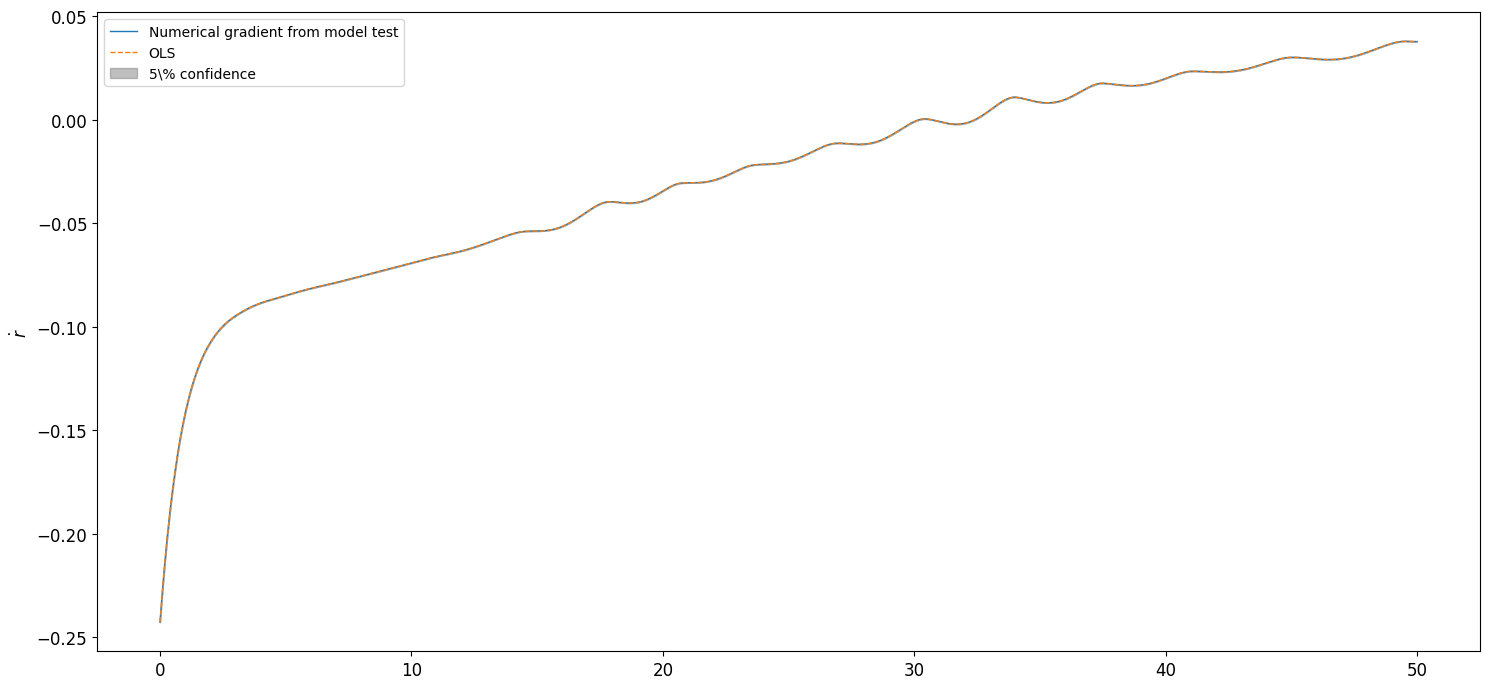

In [14]:
X = diff_eq_N.calculate_features(data=df)
y = diff_eq_N.calculate_label(y=df['r1d'])

model_N = sm.OLS(y,X)
results_N = model_N.fit()

show_pred(X=X,y=y,results=results_N, label=r'$\dot{r}$')

### Y

In [18]:
Y_ = sp.symbols('Y_')
diff_eq_Y = regression.DiffEqToMatrix(ode=vmm.Y_qs_eq.subs(Y_qs,Y_), 
                                      label=Y_, base_features=[delta,u,v,r])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    v1d   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.085e+29
Date:                Wed, 25 Aug 2021   Prob (F-statistic):               0.00
Time:                        14:15:29   Log-Likelihood:                 33468.
No. Observations:                1000   AIC:                        -6.693e+04
Df Residuals:                     995   BIC:                        -6.690e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Yur           -0.5360   2.11e-14  -2.54e+13      0.000      -0.536      -0.536
Ydelta         0.0924   8.33e-14   1.11e+12      0.000       0.092       0.092
Yr             0.2383   1.75e-14   1.36e+13      0.000       0.238       0.238
Yu          4.099e-14   2.92e-14      1.405      0.160   -1.63e-14    9.83e-14
Yv            -0.6437   1.41e-14  -4.55e+13      0.000      -0.644      -0.644
==============================================================================
Omnibus:                      342.952   Durbin-Watson:                   0.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2083.678
Skew:                          -1.437   Prob(JB):                         0.00
Kurtosis:                       9.461   Cond. No.                     5.69e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.69e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

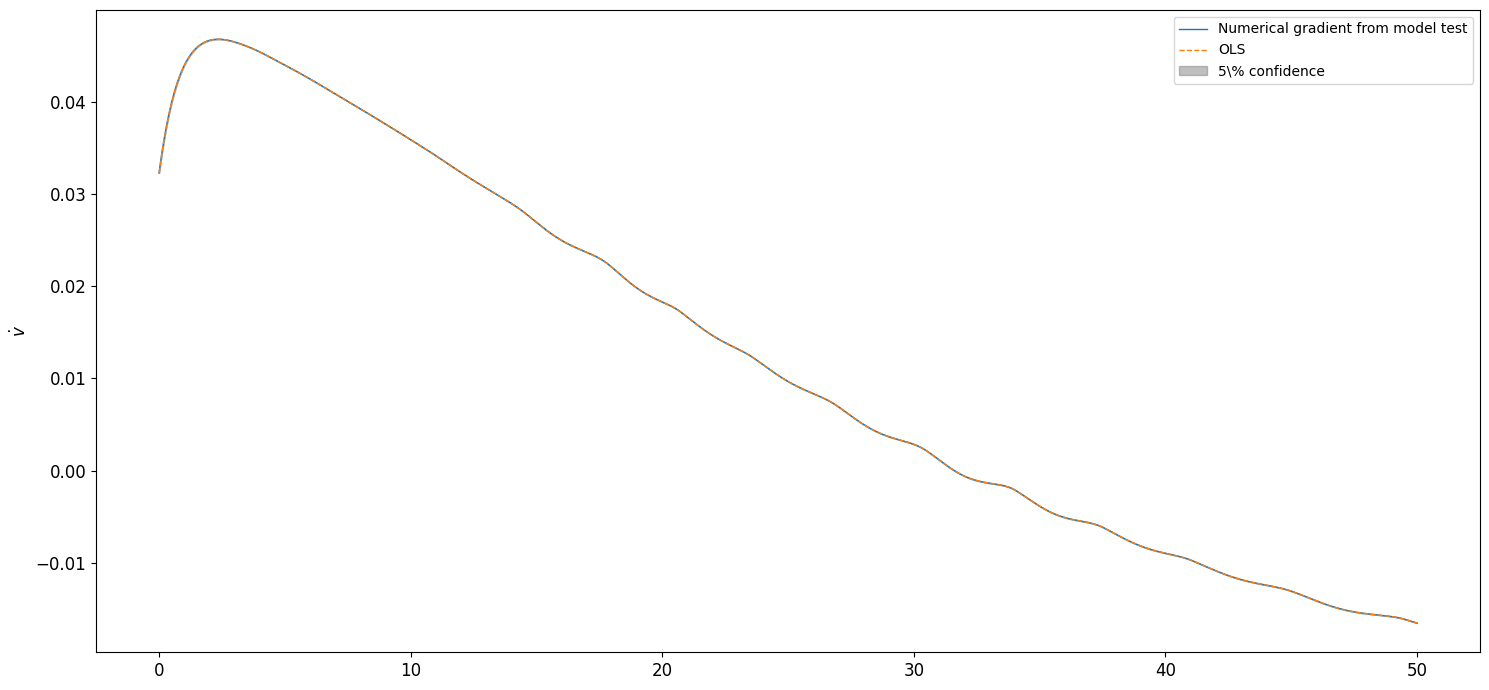

In [19]:
X = diff_eq_Y.calculate_features(data=df)
y = diff_eq_Y.calculate_label(y=df['v1d'])


model_Y = sm.OLS(y,X)
results_Y = model_Y.fit()

show_pred(X=X,y=y,results=results_Y, label=r'$\dot{v}$')

### X

In [15]:
X_ = sp.symbols('X_')
diff_eq_X = regression.DiffEqToMatrix(ode=vmm.X_qs_eq.subs(X_qs,X_), 
                                      label=X_, base_features=[delta,u,v,r,thrust])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    u1d   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.015e+25
Date:                Wed, 25 Aug 2021   Prob (F-statistic):               0.00
Time:                        14:14:40   Log-Likelihood:                 29430.
No. Observations:                1000   AIC:                        -5.885e+04
Df Residuals:                     994   BIC:                        -5.882e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Xrr         2.772e-15   1.32e-12      0.002      0.998   -2.58e-12    2.59e-12
Xvr            0.1460   5.54e-12   2.63e+10      0.000       0.146       0.146
Xdelta      1.843e-13   5.18e-11      0.004      0.997   -1.01e-10    1.02e-10
Xr         -2.819e-17   3.91e-13  -7.21e-05      1.000   -7.67e-13    7.67e-13
Xu         -1.082e-13   1.81e-11     -0.006      0.995   -3.56e-11    3.54e-11
Xv          9.541e-17   8.63e-13      0.000      1.000   -1.69e-12    1.69e-12
==============================================================================
Omnibus:                    29212.399   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.522
Skew:                           0.234   Prob(JB):                     1.63e-19
Kurtosis:                       1.637   Cond. No.                     5.79e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.79e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

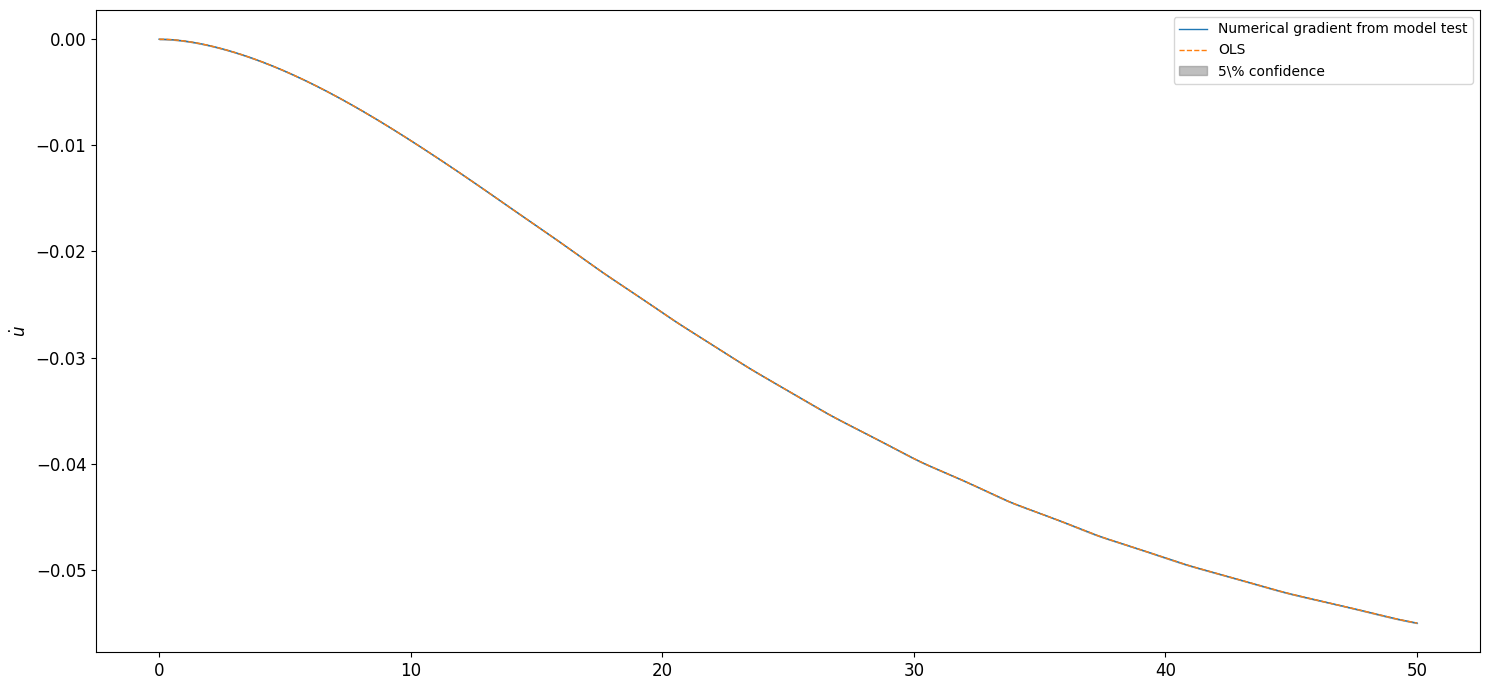

In [16]:
X = diff_eq_X.calculate_features(data=df)
y = diff_eq_X.calculate_label(y=df['u1d'])

model_X = sm.OLS(y,X)
results_X = model_X.fit()

show_pred(X=X,y=y,results=results_X, label=r'$\dot{u}}$')

### Decoupling

In [20]:
subs = {value:key for key,value in p.items()}
A_ = A*sp.matrices.MutableDenseMatrix([A_coeff,B_coeff,C_coeff])
A_lambda=lambdify(A_.subs(subs))

In [24]:
results_summary_X = regression.results_summary_to_dataframe(results_X)
results_summary_Y = regression.results_summary_to_dataframe(results_Y)
results_summary_N = regression.results_summary_to_dataframe(results_N)

A_coeff_ = results_summary_X['coeff']
B_coeff_ = results_summary_Y['coeff']
C_coeff_ = results_summary_N['coeff']

coeffs = run(A_lambda,A_coeff=A_coeff_.values, B_coeff=B_coeff_.values, C_coeff=C_coeff_.values, 
    **df_parameters['prime'], **ship_parameters_prime)

<lambdifygenerated-36>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return (array([[A_coeff*(-Xudot + m)], [B_coeff*(-Yvdot + m) + C_coeff*(-Yrdot + m*x_G)], [B_coeff*(-Nvdot + m*x_G) + C_coeff*(I_z - Nrdot)]]))


The way that the regression is formulated, inertial forces, such as centrifugal force will be included into the derivatives (I think) which means that centrifugal force : $-m \cdot r \cdot u$ will be included into $Y_{ur}$ coefficient. This coefficient is therefore not pure hydrodynamic, and can potentially be counted twice..?
The coefficients are recalculated below to avooid this:

In [25]:
results_summary_X['decoupled'] = coeffs[0][0]
results_summary_Y['decoupled'] = coeffs[1][0]
results_summary_N['decoupled'] = coeffs[2][0]

x_G_ = ship_parameters_prime['x_G']
m_ = ship_parameters_prime['m']

results_summary_X.loc['Xrr','decoupled']+=(-m_*x_G_)
results_summary_X.loc['Xvr','decoupled']+=(-m_)
results_summary_Y.loc['Yur','decoupled']+=m_
results_summary_N.loc['Nur','decoupled']+=m_*x_G_

### Add the regressed parameters
Hydrodynamic derivatives that depend on acceleration cannot be obtained from the VCT regression. They are however essential if a time simulation should be conducted. These values have then been taken from Brix semi empirical formulas for the simulations below.

In [26]:
df_parameters_all = df_parameters.copy()
for other in [results_summary_X, results_summary_Y, results_summary_N]:
    df_parameters_all = df_parameters_all.combine_first(other)

df_parameters_all.rename(columns={'decoupled':'regressed'}, inplace=True)
df_parameters_all.drop(columns=['brix_lambda'], inplace=True)

df_parameters_all['regressed'] = df_parameters_all['regressed'].combine_first(df_parameters_all['prime'])  # prefer regressed
#df_parameters_all['regressed'].fillna(0,inplace=True)

# Simulation

A simulation with the regressed hydrodynamic coefficients can now be conducted. The figures below compare results from these simulation and the original data.

In [49]:
parameters=df_parameters_all['regressed'].copy()

result_regression = vmm.simulator.simulate(df_=df_result, 
                                           parameters=parameters, 
                                           ship_parameters=ship_parameters, 
                                           control_keys=['delta'], 
                                           primed_parameters=True,
                                           prime_system=ps,
                                           name='regressed')

result_regression.df_model_test=df_result  # dirty

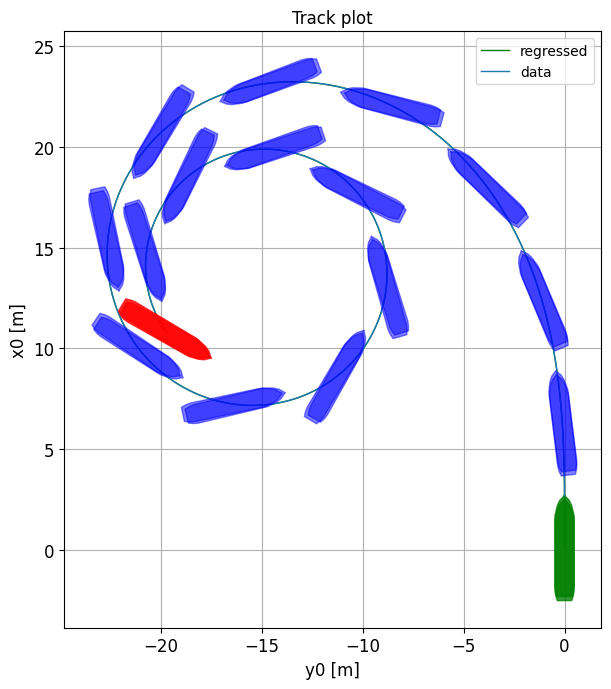

In [50]:
result_regression.track_plot(compare=True);

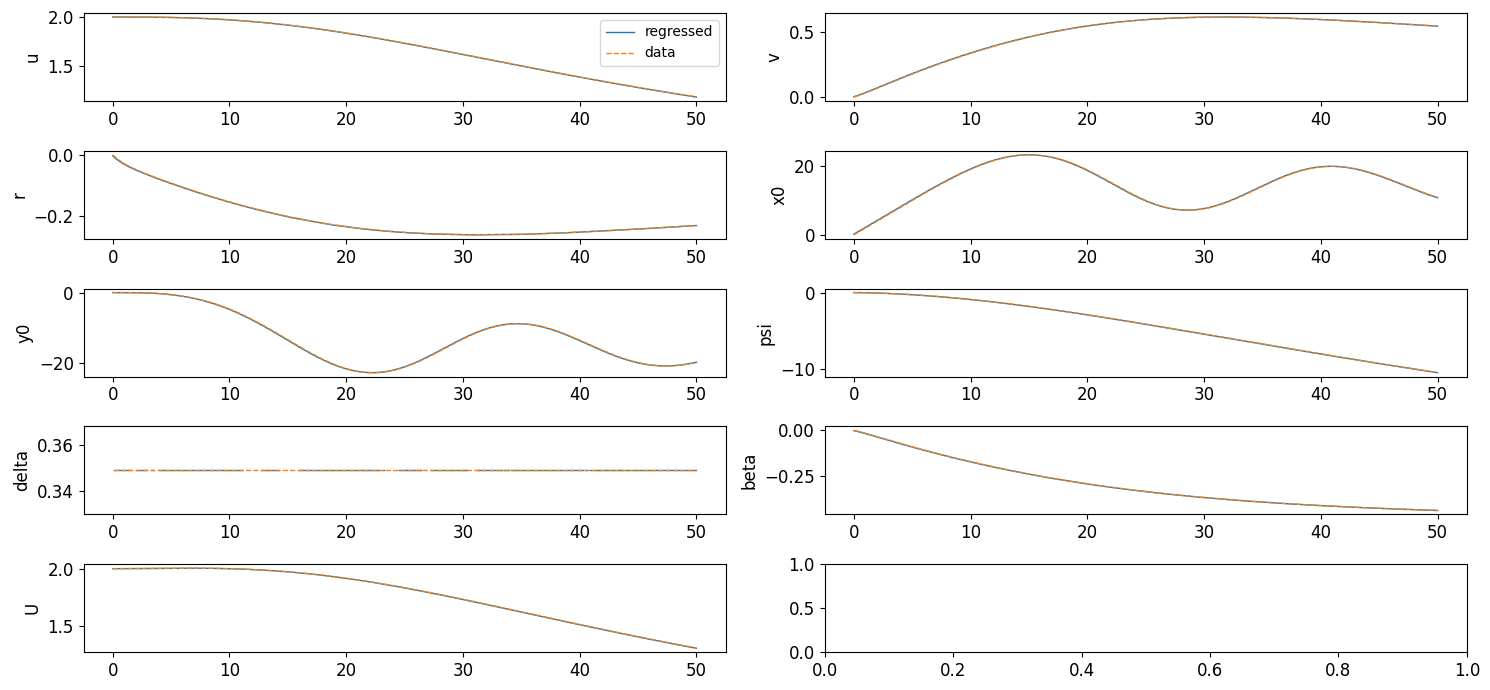

In [51]:
result_regression.plot(compare=True);

And the regressed hydrodynamic derivatives can be compared with the original parameters, refered to as "prime" in the bar chart below:

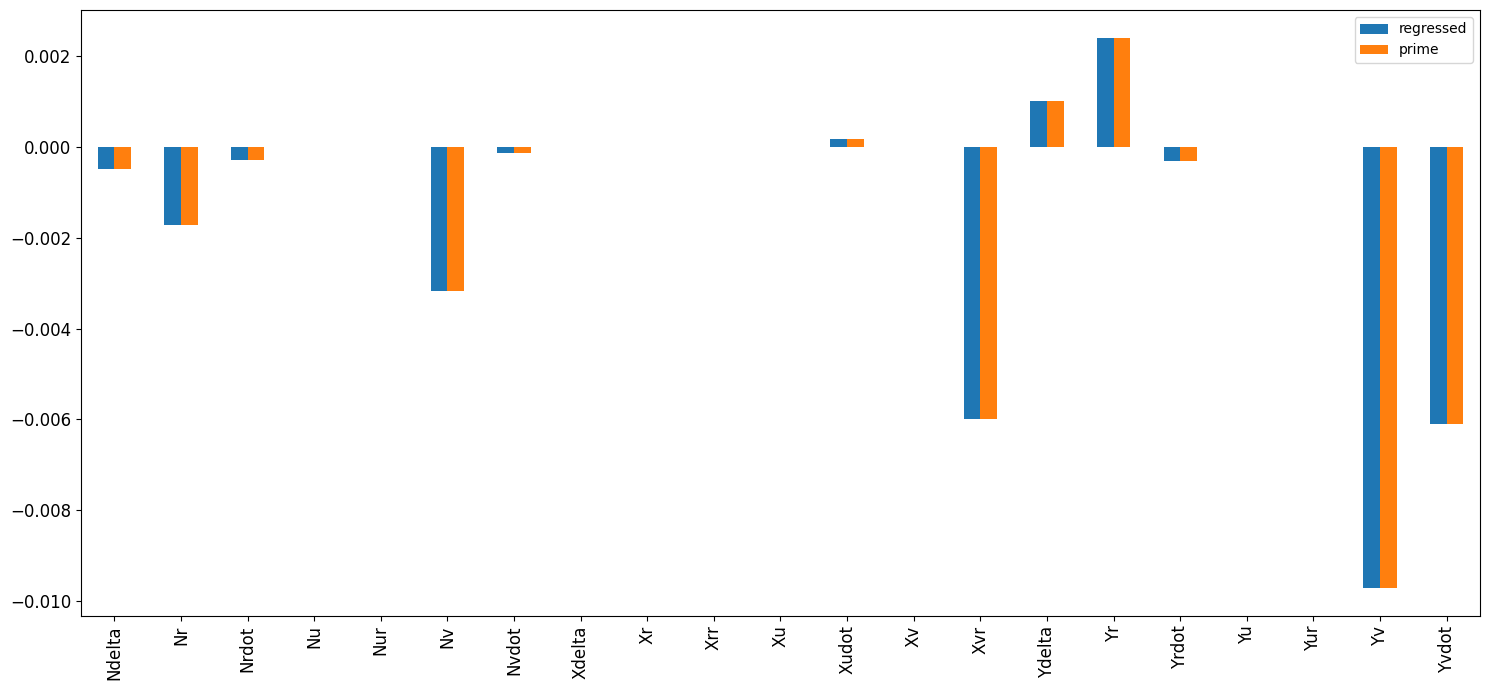

In [48]:
df_plot_parameters = df_parameters_all[['regressed','prime']].copy()
mask = ((df_plot_parameters['regressed'].abs() > 0) &
        (df_plot_parameters['regressed'].abs() < 0.99) 
       )

df_plot_parameters.loc[mask].plot(kind='bar')

mask = (
        (df_plot_parameters['regressed'].abs() > 0.99) 
       )
if mask.any():
    df_plot_parameters.loc[mask].plot(kind='bar')

## Summary
It seams that the hydrodynamic coefficients in a nonlinear manoeuvring simulation model can be identified by regressing the reversed simulation model. The example in this chapter used exact positions, velocities and accelerations, without any measurment error. This is ofcourse not possible when using real data from model test or full scale ship operations.  